# Mining ADE from English Tweets
Task 1a - Classification
GOAL: 
- Create a baseline LSTM and Multi leveled Perceptron 
- CLASSIFY IF A DRUG EVENT IS PRESENT IN A TWEET with Neural Networks- (ADE/NoADE)

## Neural Network Models:
- Recursive Neural Network (built in Pytorch by a company called Scoutbee)
- Multi Leveled Perceptron
- TF-IDF encoding

# Libraries

In [30]:
import re
import pandas as pd
import scipy as sp
import numpy as np
import scipy.sparse
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier



import random
import re
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-processing

### Contains
- Importing the data
- Text Cleaning (removing emojis)
- Stratified shuffling
- Vectorizing the Data

In [2]:

tweets = pd.read_csv('tweets.tsv', sep='\t', header=None,
                     names=['tweet_id', 'tweet'])
classes = pd.read_csv('class.tsv', sep='\t', header=0)

data = pd.merge(tweets, classes, how='left')

data = data.replace(r'@\w+', '', regex=True)

# remove any emoji from the tweet
data = data.replace(r'[^\w\s]', '', regex=True)

data = data.replace(['NoADE', 'ADE'], [0, 1])


strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=691)
X = data['tweet'].to_numpy()
y = data['label'].to_numpy()

for train_index, test_index in strat_split.split(X, y):
    print(f"Train index: {train_index}", f"Test index: {test_index}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# 4. text representation
# convert tweets to matrix of word counts and remove stop words


countvec = CountVectorizer(stop_words='english')

# normalise count matrix to decrease the effect of word frequencies


tfidf = TfidfTransformer()

# vectorize and transform train and test data
train_transformed = tfidf.fit_transform(countvec.fit_transform(X_train))
test_transformed = tfidf.transform(countvec.transform(X_test))

Train index: [ 3360  9091  6988 ...   910 12559   444] Test index: [ 5122  1796   298 ...  1025  2309 14625]


# Creating a simple Feed Foward Network Model in Sklearn

In [3]:
from sklearn.neural_network import MLPClassifier

activation = 'logistic'
nnet = MLPClassifier(solver='adam', random_state=691, max_iter=300, activation = activation)

# fit
nnet.fit(train_transformed, y_train)
y_pred = nnet.predict(test_transformed)

# print results
print("Multilayer Perceptron: with sigmoid activation")
print(f"AUC: {roc_auc_score(y_test, y_pred)}")  #0.6867425757489182
print(f"Precision: {precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)[0]:.2f}") # 0.53
print(f"Recall: {precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)[1]:.2f}") # 0.40
print(f"F1 Score: {precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)[2]:.2f}") # 0.46

Multilayer Perceptron: with sigmoid activation
AUC: 0.6867425757489182
Precision: 0.53
Recall: 0.40
F1 Score: 0.46


Model did ok in ADE classification

# LSTM model
## This pipeline was written by the github user Scoutbee where code comes from.
### German Company that created and visualized demos on how to use NLP with packages
https://github.com/scoutbee/pytorch-nlp-notebooks
https://scoutbee.com/about/

https://colab.research.google.com/github/scoutbee/pytorch-nlp-notebooks/blob/master/3_rnn_text_classification.ipynb#scrollTo=dbeeNjQoltCa

# Text Preprocessing

Contains:
- Removing rare words
- Tokenizing the data and adding tags

In [10]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens
            else '<UNK>' for token in tokens][-max_len:]


def tokenize(text, stop_words):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = wordpunct_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens


class ADE_Cleaner(Dataset):
    def __init__(self, data, max_vocab, max_len):
        df = data

        # Clean and tokenize
        print(df.columns)
        stop_words = set(stopwords.words('english')) 
        df['tokens'] = df.tweet.progress_apply(
            partial(tokenize, stop_words=stop_words),
        )
        
        # Replace rare words with <UNK>
        all_tokens = [sublst for lst in df.tokens.tolist() for sublst in lst]
        common_tokens = set(list(zip(
            *Counter(all_tokens).most_common(max_vocab)))[0])
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]
        
        vocab = sorted({
            sublst for lst in df.tokens.tolist() for sublst in lst
        })
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1
        
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
        df['indexed_tokens'] = df.tokens.apply(
            lambda tokens: [self.token2idx[token] for token in tokens],
        )
        self.text = df.tweet.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.targets = df.label.tolist()

    def __getitem__(self, i):
        return self.sequences[i], self.targets[i],  self.text[i]
    
    def __len__(self):
        return len(self.sequences)

Split the dataset to train validation and test set and fit the data into a variable

In [5]:
def Model_split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

In [13]:
# How many of the most common vocab words to keep
# Uncommon words get replaced with unknown token <UNK>
max_vocab = 100000  #@param {type:"integer"}

# How many tokens long each sequence will be cut to
# Shorter sequences will get the padding token <PAD>
max_len = 3000  #@param {type:"slider", min:16, max:512, step:2}

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()


dataset = ADE_Cleaner(data, max_vocab, max_len)

/var/folders/dk/7dw_676n7xbg0q3jb0ll59400000gn/T/ipykernel_51628/2570516656.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

Index(['tweet_id', 'tweet', 'label'], dtype='object')


  0%|          | 0/17120 [00:00<?, ?it/s]

  0%|          | 0/17120 [00:00<?, ?it/s]

  0%|          | 0/17120 [00:00<?, ?it/s]

In [60]:
valid_ratio = 0  
test_ratio = 0.05 

train_dataset, valid_dataset, test_dataset = Model_split_train_valid_test(
    dataset, valid_ratio=valid_ratio, test_ratio=test_ratio)
len(train_dataset), len(valid_dataset), len(test_dataset)

def concatenate(batch):
    a = [z[0] for z in batch]
    b = torch.LongTensor([item[1] for item in batch])
    c = [z[2] for z in batch]
    return a, b, c

batch_size = 1024 

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=concatenate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=concatenate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=concatenate)

print(len(train_dataset))
print(len(test_dataset))

16264
856


# Recursive model to predict ADE

In [28]:
def pad_sequences(sequences, padding_val=0, pad_left=False):
    sequence_length = max(len(sequence) for sequence in sequences)
    if not pad_left:
        return [
            sequence + (sequence_length - len(sequence)) * [padding_val]
            for sequence in sequences
        ]
    return [
        (sequence_length - len(sequence)) * [padding_val] + sequence
        for sequence in sequences
    ]


class RecursiveNeuralNetworkC(nn.Module):
    def __init__(self, output_size, hidden, vocab_size, padding_idx,
                 device, dropout=0.3, bidirectional=False, n_layers=1,
                 embedding_dimension=50, batch_size=32):
        super(RecursiveNeuralNetworkC, self).__init__()
        self.hidden = hidden
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.device = device
        self.padding_idx = padding_idx
        
        self.input_size_factor = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size, embedding_dimension)
        
        self.rnn = nn.LSTM(
            embedding_dimension,
            self.hidden,
            self.n_layers,
            bidirectional=bidirectional,
        )

        self.fc1 = nn.Linear(
            self.hidden * self.input_size_factor,
            16,
        )
        self.fc2 = nn.Linear(
            16,
            self.output_size,
        )


    def init_hidden(self):
        #Two hidden states that are initialized
        h0 = torch.randn(
            self.n_layers * self.input_size_factor,
            self.batch_size,
            self.hidden,
        )
        c0 = torch.randn(
            self.n_layers * self.input_size_factor,
            self.batch_size,
            self.hidden,
        )
        
        h0 = h0.to(self.device)
        c0 = c0.to(self.device)

        return h0, c0
    
    def apply_rnn(self, embedding_out, lengths):
        packed = pack_padded_sequence(
            embedding_out,
            lengths,
            batch_first=True,
        )
        activations, _ = self.rnn(packed, self.init_hidden())
        activations, _ = pad_packed_sequence(activations, batch_first=True)
        
        indices = (lengths - 1).view(-1, 1).expand(
            activations.size(0), activations.size(2),
        ).unsqueeze(1)
        indices = indices.to(self.device)
        
        activations = activations.gather(1, indices).squeeze(1)
        return activations

    def forward(self, inputs, return_activations=False):
        batch_size = len(inputs)
    
        # This makes the model not break for the last batch that might be less
        # than batch_size in size
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        lengths = torch.LongTensor([len(x) for x in inputs])
        lengths, permutation_indices = lengths.sort(0, descending=True)

        # Pad sequences so that they are all the same length
        padded_inputs = pad_sequences(inputs, padding_val=self.padding_idx)
        inputs = torch.LongTensor(padded_inputs)

        # Sort inputs
        inputs = inputs[permutation_indices].to(self.device)
        
        # Get embeddings
        embedding_out = self.embedding(inputs)
        
        activations = self.apply_rnn(embedding_out, lengths)

        x = F.dropout(torch.relu(self.fc1(activations)), 0.05)
        x = self.fc2(x)
        out = torch.sigmoid(x)

        # Put the output back in correct order
        permutation_index_pairs = list(zip(
            permutation_indices.tolist(),
            list(range(len(permutation_indices))),
        ))
        reordered_indices = [
            pair[1] for pair
            in sorted(permutation_index_pairs, key=lambda pair: pair[0])
        ]

        if return_activations:
            return out[reordered_indices], x[reordered_indices]

        return out[reordered_indices]

# Fitting the model

In [36]:
dropout = 0.15  
n_rnn_layers = 2  
embedding_dimension = 256 
hidden_size = 64  
is_bidirectional = True 
max_epochs = 15  
learning_rate = 0.001  

model = RecursiveNeuralNetworkC(
    output_size=2,  
    hidden=hidden_size,
    embedding_dimension=embedding_dimension,
    vocab_size=len(dataset.token2idx),
    padding_idx=dataset.token2idx['<PAD>'],
    dropout=dropout,
    bidirectional=is_bidirectional,
    n_layers=n_rnn_layers,
    device=device,
    batch_size=batch_size,
)

print(model)

RecursiveNeuralNetworkC(
  (embedding): Embedding(24411, 256)
  (rnn): LSTM(256, 64, num_layers=2, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)


In [37]:
def train_epoch(model, optimizer, scheduler, train_loader):
    model.train()
    total_loss = total = 0
    progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)
    for inputs, target, text in progress_bar:
        target = target.to(device)

        optimizer.zero_grad()

        output = model(inputs)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss = total = 0
    with torch.no_grad():
        progress_bar = tqdm_notebook(valid_loader, desc='Validating', leave=False)
        for inputs, target, text in progress_bar:
            target = target.to(device)

            output = model(inputs)

            loss = criterion(output, target)

            total_loss += loss.item()
            total += len(target)

    return total_loss / total

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
)
scheduler = CosineAnnealingLR(optimizer, 1)

# Training the model

In [63]:
n_epochs = 0
train_losses, valid_losses = [], []
for _ in range(max_epochs):
    train_loss = train_epoch(model, optimizer, scheduler, train_loader)
    valid_loss = validate_epoch(model, test_loader)
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}'
        f'\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss
                                     for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

/var/folders/dk/7dw_676n7xbg0q3jb0ll59400000gn/T/ipykernel_51628/1169750039.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)


Training:   0%|          | 0/16 [00:00<?, ?it/s]

/var/folders/dk/7dw_676n7xbg0q3jb0ll59400000gn/T/ipykernel_51628/1169750039.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(valid_loader, desc='Validating', leave=False)


Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch #  1	train_loss: 3.78e-04	valid_loss: 4.55e-04



Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch #  2	train_loss: 3.78e-04	valid_loss: 4.55e-04



Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch #  3	train_loss: 3.78e-04	valid_loss: 4.55e-04



Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch #  4	train_loss: 3.78e-04	valid_loss: 4.55e-04



Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch #  5	train_loss: 3.78e-04	valid_loss: 4.55e-04



Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch #  6	train_loss: 3.78e-04	valid_loss: 4.55e-04



Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch #  7	train_loss: 3.78e-04	valid_loss: 4.55e-04



Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch #  8	train_loss: 3.78e-04	valid_loss: 4.55e-04



Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch #  9	train_loss: 3.78e-04	valid_loss: 4.55e-04



Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch # 10	train_loss: 3.78e-04	valid_loss: 4.55e-04



Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

epoch # 11	train_loss: 3.77e-04	valid_loss: 4.55e-04

Stopping early


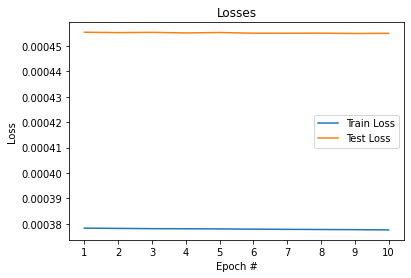

In [64]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Test Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [65]:
model.eval()
test_accuracy = n_examples = 0
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, target, text in tqdm_notebook(test_loader, leave=False):
        target = target.to(device)

        _, logits = model(inputs, return_activations=True)

        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)
        
print(classification_report(y_true, y_pred))

/var/folders/dk/7dw_676n7xbg0q3jb0ll59400000gn/T/ipykernel_51628/2438525842.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, target, text in tqdm_notebook(test_loader, leave=False):


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       856
           1       0.00      0.00      0.00         0

    accuracy                           0.92       856
   macro avg       0.50      0.46      0.48       856
weighted avg       1.00      0.92      0.96       856



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
